# Three-dimensional topology optimization

This notebook illustrates how to use domain decomposition and parallel computing for solving 3D topology optimization problems.
We consider a compliance minimization problem for the design of a bridge structure. We reproduce the following test case from

*Grégoire Allaire, Charles Dapogny, Pascal Frey. Shape optimization with a level set based mesh evolution method. Computer Methods in Applied Mechanics and Engineering, Elsevier, 2014, pp.doi:10.1016/j.cma.2014.08.028.*

<img src="project.png" alt="setting" style="max-height:200px;" />

The optimization problem reads:
$$
\begin{aligned}
\min & \qquad J(\Omega, u(\Omega))\\
s.t. & \qquad \mathrm{Vol}(\Omega)-\mathrm{Vol}_{target}=0
\end{aligned}
$$
where $u(\Omega)$ is the solution to
$$
\renewcommand{\u}{\textbf{u}}
\renewcommand{\f}{\textbf{f}}
\renewcommand{\In}{\text{ in }}
\renewcommand{\div}{\mathrm{div}}
\renewcommand{\Tr}{\mathrm{Tr}}
\newcommand{\On}{\textrm{ on }}
\newcommand{\n}{{\textbf n}}
\newcommand{\g}{\textbf g}
    \left\{\begin{aligned}
  -\div(Ae(\u)) &= \f \In \Omega \\
        \u &= 0 \On \partial\Omega^{D}\\
        Ae(\u)\cdot \n& = \g \On \partial \Omega^{N}\\
        Ae(\u)\cdot\n &= 0\On \Gamma.
    \end{aligned}\right.
$$
where
$$
A e(\u) = 2\mu e(\u) + \lambda \Tr(e(\u))I.
$$
We recall that the compliance and the volume are defined by
$$
J(\Omega,u(\Omega)):=\int_{\Omega}e(\u):e(\u)\mathrm{d} x,\qquad 
\mathrm{Vol}(\Omega):=\int_\Omega\mathrm{d} x.
$$
For the purpose of illustrationg parallel computing and domain decomposition method, we consider the level-set method for solving the topology optimization problem. 

Let us start by loading the necessary libraries.

In [31]:
%load_ext autoreload
%autoreload 2


from pymedit import Mesh3D, cube, mmg3d, generate3DMesh, P1Function3D, trunc3DMesh
from pymedit import saveToVtk, advect, P1Vector3D, mshdist
import numpy as np
import pyfreefem.preprocessor as preprocessor
preprocessor.ENABLE_LINE_BREAKS=False
from pyfreefem import FreeFemRunner, readFFArray
from nullspace_optimizer import Optimizable, nlspace_solve

import matplotlib.pyplot as plt
import shutil
import os
os.makedirs('output',exist_ok=True)
os.makedirs('tmp',exist_ok=True)

from xml.etree import ElementTree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define the number of processors you want to use to distribute the computation.

In [2]:
ncpu = 4

# Creation of the initial mesh

In the level set method, we work with a fixed mesh, that we are constructing now.

We are going to consider the following mesh size (we will work with a mesh of size 200x50x40.

In [3]:
hmin=1
hmax=2
hausd=0.1*hmin
hgrad=1.3

Create a mesh with a trapezoidal shape:

In [4]:
M0 = cube(10,10,10,lambda x,y,z:[200*x,50*y,40*z])

# Level set function to slice part of the mesh
phi=P1Function3D(M0,lambda x: -min(x[0]+x[1]-50,-(x[0]-200)+x[1]-50))

#Remeshing
M=mmg3d(M0,hmin,hmax,hausd,hgrad,sol=phi, ls=True,debug=1)

mmg3d_O3 -nr -hmin 1 -hmax 2 -hgrad 0.1 -hausd 1.3 -ls -sol /tmp/tmp2yppzsoo/Th.solb /tmp/tmp2yppzsoo/Th.meshb (65.72s)


Detect the ridges (to keep flat parts in the meshing process)

In [5]:
# Get the interior part
Ms=trunc3DMesh(M,3)
# Get rid of normals and tangents
del Ms.normalAtVertices
del Ms.tangentAtVertices
del Ms.tangents
del Ms.normals
Ms._AbstractMesh__updateNumbers()

# This two lines to make sure that ridges and flat faces are found correctly 
Ms.triangles[Ms.triangles[:,-1]==10,-1]=2
Ms.edges[Ms.edges[:,-1]==10,-1]=0
Ms._AbstractMesh__updateBoundaries()

# Detect ridges
Ms=mmg3d(Ms,hmin,hmax,hausd,hgrad,extra_args="-noswap -nomove -noinsert",nr=False)
#Ms.plot(keys='bceg')

Truncating mesh from region 3
Truncated mesh in 0.87s.
mmg3d_O3 -hmin 1 -hmax 2 -hgrad 0.1 -hausd 1.3 -noswap -nomove -noinsert /tmp/tmp79sdb35h/Th.meshb (0.92s)


Now we add the patches for the boundary conditions.

In [6]:
# Level set functions for the Dirichlet patches 
side1 = lambda x : max(-x[0]+x[1]+30,x[0]-x[1]-50, x[0]+x[1]-60,x[2]-35,-x[2]+5)#,x[0]+x[1]-50-0.5*x[2],x[0]+x[1]-50+0.5*x[2]-20)
side2 = lambda x: min(side1(x),side1([200-x[0],x[1],x[2]]))
top = lambda x : max(x[0]-195,-x[0]+5,45-x[1],x[2]-35,-x[2]+5)
phi=P1Function3D(Ms,side2)

# Generate the mesh with label 20 inside the patch
Th = generate3DMesh(Ms,[side2,top],[20,21],hmin,hmax,hausd,hgrad,detectCorners=False)

Th.tetrahedra[:,-1] = 2
Th.edges=Th.edges[Th.edges[:,-1]!=10,:]
Th._AbstractMesh__updateBoundaries()
Th=mmg3d(Th,hmin,hmax,hausd,hgrad)

mmg3d_O3 -nr -ls -sol /tmp/tmpkxp6wb_4/Th.solb -noswap -noinsert -nomove -nosurf /tmp/tmpkxp6wb_4/Th.meshb (1.90s)
mmg3d_O3 -nr -hmin 1 -hmax 2 -hgrad 1.3 -hausd 0.1 /tmp/tmpf7uhrp29/Th.meshb (43.08s)
Generated 3D mesh in 57.26s.
mmg3d_O3 -nr -hmin 1 -hmax 2 -hgrad 0.1 -hausd 1.3 /tmp/tmphvpy26re/Th.meshb (12.52s)


Plot the mesh and save it for later purposes.

In [7]:
#Th.plot(keys='bce')

#Save the mesh
Th.save('output/Th.meshb')

## Initial distribution of holes

Load the mesh if we start from here.

In [8]:
Th=Mesh3D('output/Th.meshb')

Define an initial level set function: three half spheres centered on the sides and at the bottom.

In [33]:
phi0 = -P1Function3D(Th,lambda x : min(np.sqrt((x[0]-100)**2+(x[1]-25)**2+x[2]**2)-10,
                                      np.sqrt((x[0]-100)**2+(x[1]-25)**2+(x[2]-40)**2)-10,
                                      np.sqrt((x[0]-100)**2+x[1]**2+(x[2]-20)**2)-10))

cut = lambda x : -max(46-x[1],x[2]-35,-x[2]+5,x[0]-195,-x[0]+5)#,-side1(x),-side2(x))

phiTest=P1Function3D(Th,cut)
newPhi = P1Function3D(Th,phi0)
newPhi.sol = -newPhi.sol
newPhi.sol = np.minimum(np.maximum(P1Function3D(Th,cut).sol,newPhi.sol),(-P1Function3D(Th,cut)).sol)
saveToVtk(Th,[phi0,phiTest,newPhi],labels=['phi','phiTest','newPhi'],orders=[1,1,1],output='tmp/cut.vtu')

Some FreeFEM code that we are going to use as a preamble to any FEM operation:

In [10]:
preamble=r"""
load "medit";
load "distance";

IF WITH_MPI
ELSE
int mpirank = 0;
ENDIF
func int display(string message, string colorCode){
    string code;
    if(colorCode=="white"){
        code="\\033[1m";
    } else if(colorCode=="dim"){
        code="\\033[2m";
    } else if(colorCode=="red"){
        code="\\033[31;1m";
    } else if(colorCode=="green"){
        code="\\033[92m";
    }  else if(colorCode=="blue"){
        code="\\033[1;34m";
    }
    string cmd="printf \""+code+message+"\\033[0m\n\"";
    exec(cmd);
}

func int disp(string message){
    if(mpirank==0)
        display(message,"green");
}
func int readSolFile(mesh3 & Th, string fileName, real[int] & phi){
    disp("Reading "+fileName);
    phi = readsol(fileName);
}

func int savesol2(string fileName,mesh3 & Th,real[int] & phi){
    fespace Fh(Th,P1);
    Fh p;
    p[]=phi;
    savesol(fileName,Th,p,order=1);
}

macro saveArray(fileName, value){
    ofstream file(fileName);
    file << value;
}//EOM

macro readData(fileName, data){
    disp("Reading "+fileName);
    {
        ifstream f(fileName);
        int n;
        f >> n;
        data.resize(n);
        for[i, v : data] f >> v;
    }
}//EOM



real tclock;//For measuring time

mesh3 Th=readmesh3("output/Th.meshb");
fespace Fh0(Th,P0);
fespace Fh1(Th,P1);
fespace Fh13d(Th,[P1,P1,P1]);
"""


Now we write a module to convert a level set phi to a signed distance function.

In [39]:
def redistantiate(phi0):
    return mshdist(Th,phi=phi0)

phi0.sol=np.maximum(-10,phi0.sol)
redist=redistantiate(phi0)
redist.save('output/phi0.sol')
saveToVtk(Th,[phi0,redist],labels=['phi0','redist'],orders=[1,1],output='tmp/redist.vtu')

Saved /tmp/tmpd4n8ticp/Th.sol in 0.10s.
Write 84364 SolAtVertices
Next position: 674952
Solution types: [1]
Saved /tmp/tmphsn4utau/phi0.solb in 0.01s.


## Domain decomposition

We now partition the mesh into `ncpu` submesh using the macro `buildDmesh` (build distributed mesh). We save it for later purposes.

In [12]:
domainDecomposition =r"""
load "PETSc";
load "iovtk";

//Domain Decomposition preamble
macro dimension()3// EOM            // 2D or 3D
include "macro_ddm.idp"             // additional DDM functions

mesh3 ThLoc;
// Partition Th 
tclock = clock();
ThLoc = Th;
int[int] n2oThLoc;
macro ThLocN2O()n2oThLoc// EOM
buildDmesh(ThLoc)
disp("Partition Th in "+(clock()-tclock));
tclock = clock();
saveDmesh(ThLoc, "tmp/ThLoc");
disp("Saved distributed meshes in "+(clock()-tclock));
"""

def initializeDDM():
    FreeFemRunner([preamble,domainDecomposition],run_file="domainDecomposition.edp",script_dir="tmp").execute(ncpu=ncpu);

initializeDDM()

'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/domainDecomposition.edp' -v 0
Partition Th in 4.0717
Saved distributed meshes in 0.118548


Next, we create a FreeFEM module that loads the distributed mesh and prepares distributed finite element spaces. This module also loads the current level set (assumed to be a signed distance function).

In [13]:
loadddm=r"""
load "PETSc";
load "iovtk";

//Domain Decomposition preamble
macro dimension()3// EOM            // 2D or 3D
include "macro_ddm.idp"             // additional DDM functions

mesh3 ThLoc;
int[int] n2oThLoc;
macro ThLocN2O()n2oThLoc// EOM
loadDmesh(ThLoc,"tmp/ThLoc"); //Load distributed mesh

// Useful macros for 
// projecting quantity defined on a mesh to a submesh and vice versa
// First argument is output
macro globalToLocal(phiLocal,phiGlobal,rest) for [i, v : rest ] phiLocal[i] = phiGlobal[v]; //EOM
macro localToGlobal(phiGlobal,phiLocal,rest) for [i, v : rest ] phiGlobal[v] = phiLocal[i];//EOM

// Distributed finite element spaces
fespace Fh0Loc(ThLoc, P0);
fespace Fh1Loc(ThLoc, P1);
fespace Fh13dLoc(ThLoc, [P1, P1, P1]); // FEM space for linear elasticity

// Get a partition of unity for local to global operations
Fh0Loc DTh;
Fh1Loc DFh1;
createPartition(ThLoc, DTh[], P0) 
createPartition(ThLoc, DFh1[], P1)

// Get restrictions operators (from Global FEM space to local ones)
int[int] restFh0 = restrict(Fh0Loc, Fh0, n2oThLoc);
int[int] restFh1  = restrict(Fh1Loc, Fh1, n2oThLoc);
int[int] restFh13d = restrict(Fh13dLoc, Fh13d, n2oThLoc);

// Load the signed distance function
Fh1 phiGlobal;
readSolFile(Th,"$PHI",phiGlobal[]);
Fh1Loc phi;
globalToLocal(phi[],phiGlobal[],restFh1);

//Save this to paraview file.
{
string DataName = "phi";
int[int] Order=[1];
savevtk("tmp/output.vtu",ThLoc, phi, dataname=DataName, order=Order);
}
"""
FreeFemRunner([preamble,loadddm],
              run_file="loadphi.edp",
              script_dir="tmp").execute(ncpu=ncpu,config={'PHI':'output/phi0.sol'});


'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/loadphi.edp' -v 0
Reading output/phi0.sol


Visualise the domain decomposition with paraview. Open the `output_8.pvd` file. Then threshold the `label` between 0 and 20 and apply the filter `MergeBlocks` to remove ghost cells. Then plot the zero level-set using `Contour`.

## Solving the linear elasticity system

We now solve the linear elasticity problem. In the level-set method where we use a fixed mesh, we use the ersatz material method whereby we solve
$$
    \left\{\begin{aligned}
  -\div(A(\Omega)e(\u)) &= \f \In D \\
        \u &= 0 \On \Gamma^{D}\\
        A(\Omega)e(\u)\cdot \n& = \g \On \partial \Gamma^{N}\\
        A(\Omega)e(\u)\cdot\n &= 0\On D\backslash(\Gamma^D\cup\Gamma^N).
    \end{aligned}\right.
$$
where 
$$
A(\Omega)=A 1_\Omega + \epsilon A (1-1_\Omega)
$$
for a small parameter $\epsilon>0$. In $D\setminus \Omega$, the material is very soft and behaves almost as void. 
In the context of the level-set method, we approximate the characteristic function $1_\Omega$ by $H(-d_\Omega)$
where $d_\Omega$ is the signed distance function and $H$ a smoothened Heaviside function:
$$
\newcommand{\If}{\text{ if }}
\newcommand{\<}{\leqslant}
H(t)=\left\{\begin{aligned}
0 & \If t< -\frac{\gamma}{2}\\
\frac{1}{2}+\frac{t}{\gamma}+\frac{1}{2\pi}\sin\left( \frac{2\pi t}{\gamma}\right) & \If -\frac{\gamma}{2} \< t \< \frac{\gamma}{2}\\
1 & \If t>\frac{\gamma}{2}
\end{aligned}\right.
$$
The parameter $\gamma$ determines the interpolation width for the Heaviside function. Since we consider $H(-d_\Omega)$, we set $\gamma=1.5\texttt{hmax}$, which corresponds to an interpolation width of 1.5 the size of the largest mesh element. 

We use therefore the approximation
$$
A(\Omega)=A H(-d_\Omega)+\epsilon A (1-H(-d_\Omega)).
$$

Let us implement a few useful macros.

In [14]:
utils=r"""
//Physical parameters
real E=15;
real poisson=0.35;
real lambda=E*poisson/((1.+poisson)*(1.-2.*poisson));
real mu=E/(2.*(1.+poisson));

// Material interpolation parameters
real gam=1.5*$hmax;
macro heaviside(x) ((x < gam/2 && x>=-gam/2)*(0.5+x/gam+sin(2*pi*x/gam)/(2*pi))+1.0*(x>=gam/2))//
macro dirac(x) ((x < gam/2 && x>=-gam/2)*(1/gam+1/gam*cos(2*pi*x/gam)))//

real epsElasticity=1e-3;
//By convention, phi<0 in solid
macro lambdaChi(phi) (heaviside(-phi)+(1-heaviside(-phi))*epsElasticity)*lambda//
macro muChi(phi) (heaviside(-phi)+(1-heaviside(-phi))*epsElasticity)*mu//

// Differential operators for the variational formulation
real sqrt2=sqrt(2);
macro grad(u)            [dx(u),dy(u),dz(u)]//
macro e(vx,vy,vz)        [dx(vx),dy(vy),dz(vz),(dx(vy)+dy(vx))/sqrt2, (dx(vz)+dz(vx))/sqrt2, (dy(vz)+dz(vy))/sqrt2]//
macro div(vx,vy,vz)      (dx(vx)+dy(vy)+dz(vz))//

//Total volume
real Vth = int3d(Th)(1.);
"""

#We will need to specify the value of $hmax when calling FreeFEM from python.
config={'hmax':hmax}

We now solve the linear elasticity problem in parallel. We also compute the objective and constraint functions. We use the GAMG preconditioner.

In [15]:
solvestate=r"""
Fh13dLoc [ux,uy,uz],[rx,ry,rz]; // The displacement variable and test function

// The load at the top of the bridge
real gx=0;
real gy=-1;
real gz=0;

//======================Assembling the FEM Matrix============================//

// Reminder: 20 is Dirichlet boundary, 3 is top boundary
varf linearElasticity([ux,uy,uz],[rx,ry,rz])=
    int3d(ThLoc)(2*muChi(phi)*e(ux,uy,uz)'*e(rx,ry,rz)
                            +lambdaChi(phi)*div(ux,uy,uz)*div(rx,ry,rz))
    +on(20, ux=0,uy=0,uz=0);
    
varf elasticityRhs([ux,uy,uz],[rx,ry,rz])=
    int2d(ThLoc,21)([gx, gy, gz]'*[rx,ry,rz])
    +on(20, ux=0,uy=0,uz=0);

Mat AElasticity;//Global distributed matrix
{
macro def(i)[i, i#B, i#C]// EOM     // vector field definition
macro init(i)[i, i, i]// EOM        // vector field initialization
createMat(ThLoc,AElasticity,[P1,P1,P1]) //Create a distributed matrix
}

//Assemble the distributed matrix and RHS in parallel!
tclock = clock();
real[int] rhsElasticity = elasticityRhs(0,Fh13dLoc,tgv=-1);
AElasticity = linearElasticity(Fh13dLoc,Fh13dLoc,tgv=-1); 
disp("Assembled  linear elasticity problem in "+(clock()-tclock));

//==================== Setting the preconditionner ================================//

//Rigid body modes required by the preconditioner
Fh13dLoc<real> [Rb, RbB, RbC][6];
[Rb[0], RbB[0], RbC[0]] = [1, 0, 0];
[Rb[1], RbB[1], RbC[1]] = [0, 1, 0];
[Rb[2], RbB[2], RbC[2]] = [0, 0, 1];
[Rb[3], RbB[3], RbC[3]] = [y, -x, 0];
[Rb[4], RbB[4], RbC[4]] = [-z, 0, x];
[Rb[5], RbB[5], RbC[5]] = [0, z, -y];

string petscoptions="-pc_type gamg -ksp_type gmres -ksp_max_it 200 -pc_gamg_threshold 0.01"+ 
                    " -pc_gamg_sym_graph true "; // Geometric Algebraic MultiGrid preconditioner
                    
set(AElasticity, sparams = petscoptions, nearnullspace = Rb, bs=3);

//======================Solve the linear problem in parallel===============================//
tclock=clock();
ux[] = AElasticity^-1*rhsElasticity;
disp("Solved linear elasticity problem in "+(clock()-tclock));

//============ Compute objective and constraint functions in parallel ======//
//For a weird perfomance reason we need to get components of [ux,uy,uz] separately
Fh1Loc ux1, uy1, uz1;
ux1=ux;
uy1=uy;
uz1=uz;

//Use the partition of unity DTh
tclock=clock();
//Naive
//real JLoc = int3d(ThLoc)(DTh*(2*muChi(phi)*e(ux1,uy1,uz1)'*e(ux1,uy1,uz1)+lambdaChi(phi)*div(ux1,uy1,uz1)*div(ux1,uy1,uz1)));
//More efficient
real JLoc = ux[]'*rhsElasticity;
//real JLoc = int3d(ThLoc,qforder=3)(DTh*heaviside(-phi)*(2*muChi(phi)*e(ux1,uy1,uz1)'*e(ux1,uy1,uz1)+lambdaChi(phi)*div(ux1,uy1,uz1)*div(ux1,uy1,uz1)));
real GLoc = int3d(ThLoc)(DTh*heaviside(-phi))/Vth-0.15/mpisize;

real J, G;
mpiReduce(JLoc,J, processor(0), mpiSUM); //Synchronisation operation: sum all JLoc
mpiReduce(GLoc,G, processor(0), mpiSUM);
disp("Computed objective function in "+(clock()-tclock));

//=================Save the solution and objective and constraint functions ===============================//
saveArray("tmp/ux_"+mpirank+".gp",ux[]);
{
string DataName = "phi u";
int[int] Order=[1,1];
savevtk("tmp/output.vtu",ThLoc, phi, [ux,uy,uz], dataname=DataName, order=Order);
}

if(mpirank==0)
{
    {
    ofstream f("tmp/J.gp");
    f.precision(16);
    f << J << endl;
    }
    {
    ofstream f("tmp/G.gp");
    f.precision(16);
    f << G << endl;
    }
}
"""

def solveState(phi): 
    FreeFemRunner([preamble,loadddm,utils,solvestate],
                  config=config,run_file="solvestate.edp",
                  script_dir="tmp").execute(ncpu=ncpu,config={'PHI':phi});
    with open('tmp/J.gp','r') as f:
        J = float(f.readlines()[0])
    with open('tmp/G.gp','r') as f:
        G = float(f.readlines()[0])
    return (J,G)

(J,G) = solveState('output/phi0.sol')
print(f"J={J}")
print(f"G={G}")


'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading output/phi0.sol
Assembled  linear elasticity problem in 8.45818
Solved linear elasticity problem in 4.86185
Computed objective function in 0.807168
J=55551.23196268856
G=0.8292062496711802


Visualise with paraview. Observe the deformation.

## Assembling shape derivatives and shape gradients

We now compute the shape derivative. We can easily compute
$$
\newcommand{\D}{\mathrm{d}}
\newcommand{\Vol}{\mathrm{Vol}}
  \frac{\D}{\D\theta}\Big[ J(\Omega,\u(\Omega))\Big]
  (\theta)=-\int_D \frac{\D}{\D \theta}[A(\Omega)](\theta) e(\u):e(\u)\D x
$$
where
$$
\frac{\D}{\D \theta}[A(\Omega)](\theta)=(1-\epsilon)H'(-d_\Omega)(-d'_\Omega(\theta)).
$$
The function $d'_\Omega(\theta)$ is the Eulerian derivative of the signed distance function. We shall replace it by a test function $V$ since in the vicinity of $\partial\Omega$, we have $d'_\Omega(\theta)\simeq {{\theta}}\cdot\n$.
We have also
$$
  \frac{\D}{\D\theta}\Big[ \Vol(\Omega)\Big]=\int_D H'(-d_\Omega)(-d'_\Omega(\theta))\D x.
$$
Therefore in what follows, we implement these shape derivatives using $V=-d'_\Omega(\theta)$ as a test function. Then we identify the gradient by solving a Laplace problem, e.g.
$$
    \int_D \gamma^2 \nabla V\cdot\nabla V'+VV' \D x = -\int_D (1-\epsilon)H'(-d_\Omega)Ae(\u):e(\u)V\D x
$$
for $\gamma=3\texttt{hmax}$. Then a descent direction will be constructed by taking $\theta=V\nabla d_\Omega$ as a displacement vector field.

In [16]:
sensitivity=r"""
//Load the displacement
Fh13dLoc [ux,uy,uz],[rx,ry,rz]; // The displacement variable and test function
readData("tmp/ux_"+mpirank+".gp",ux[]);
Fh1Loc ux1, uy1, uz1;
ux1=ux; uy1=uy; uz1=uz;

//Test functions for the shape derivative
Fh1Loc V,Vp;

// Shape derivative for the compliance
varf djdtheta(V,Vp)=int3d(ThLoc)(-(1-epsElasticity)*dirac(-phi)*(2*mu*e(ux1,uy1,uz1)'*e(ux1,uy1,uz1)
                        +lambda*div(ux1,uy1,uz1)*div(ux1,uy1,uz1))*Vp);
real[int] diffJLoc = djdtheta(0,Fh1Loc,tgv=-1);

// Shape derivative for the volume
varf dgdtheta(V,Vp)=int3d(ThLoc)(dirac(-phi)/Vth*Vp);
real[int] diffGLoc = dgdtheta(0,Fh1Loc,tgv=-1);



//========================== Shape gradients ============================================//

//Poisson problem for the riesz identification with zero boundary conditions on non optimizable parts
real gamma=5*$hmax;
varf riesz(V,Vp)=int3d(ThLoc)(gamma^2*grad(V)'*grad(Vp)+V*Vp);
//    +on(21,V=0);
Mat ARiesz;//Distributed matrix
createMat(ThLoc,ARiesz,P1) //Create a distributed matrix

ARiesz=riesz(Fh1Loc,Fh1Loc,tgv=-1);

tclock = clock();
set(ARiesz,sparams="-pc_type hypre");//Use hypre solver
real[int] gradJLoc(Fh1Loc.ndof), gradGLoc(Fh1Loc.ndof);
gradJLoc = ARiesz^-1*diffJLoc;
gradGLoc = ARiesz^-1*diffGLoc;

//Assemble global shape derivatives
Fh1 diffJ, diffG;
Fh1Loc gradjloc, gradgloc;
gradjloc[]=gradJLoc; gradgloc[]=gradGLoc;
diffJLoc .*= DFh1[];//Multiply by partition of unity
diffGLoc .*= DFh1[];
real[int] diffJreduced(Fh1.ndof), diffGreduced(Fh1.ndof);
localToGlobal(diffJreduced, diffJLoc, restFh1);
localToGlobal(diffGreduced, diffGLoc, restFh1);
mpiAllReduce(diffJreduced, diffJ[], mpiCommWorld, mpiSUM);
mpiAllReduce(diffGreduced, diffG[], mpiCommWorld, mpiSUM);
disp("Assembled shape derivatives in "+(clock()-tclock));

{
string DataName = "phi u gradJ gradG";
int[int] Order=[1,1,1,1];
savevtk("tmp/output.vtu",ThLoc, phi, [ux,uy,uz], gradjloc, gradgloc, dataname=DataName, order=Order);
}
// Assemble global gradients
gradJLoc .*= DFh1[];
gradGLoc .*= DFh1[];
real[int] reducedGradJ(Fh1.ndof), reducedGradG(Fh1.ndof);
localToGlobal(reducedGradJ,gradJLoc, restFh1);
localToGlobal(reducedGradG,gradGLoc, restFh1);
Fh1 gradJ, gradG;
mpiAllReduce(reducedGradJ, gradJ[], mpiCommWorld, mpiSUM);
mpiAllReduce(reducedGradG, gradG[], mpiCommWorld, mpiSUM);

//============================ Save gradients and differential =========================================//


//Save Shape derivative and gradients
if(mpirank==0){
    saveArray("tmp/diffJ.gp",diffJ[]);
    saveArray("tmp/diffG.gp",diffG[]);
    saveArray("tmp/gradJ.gp",gradJ[]);
    saveArray("tmp/gradG.gp",gradG[]);
}
"""

def compute_sensitivity(phi):
    FreeFemRunner([preamble,loadddm,utils,sensitivity],
                  config=config,run_file="sensitivities.edp",
                  script_dir="tmp").execute(ncpu=ncpu, config={'PHI':phi})
    dJ=readFFArray('tmp/diffJ.gp')
    dG=readFFArray('tmp/diffG.gp')
    gradJ=readFFArray('tmp/gradJ.gp')
    gradG=readFFArray('tmp/gradG.gp')
    return (dJ,dG,gradJ,gradG)

(dJ,dG,gradJ,gradG) = compute_sensitivity('output/phi0.sol')

'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/sensitivities.edp' -v 0
Reading output/phi0.sol
Reading tmp/ux_0.gp
Assembled shape derivatives in 1.0619


# Level set advection

The next step is to implement a function which given a descent direction returns the updated level set. 

In [17]:
regularize=r"""
Fh1 newphi;
readSolFile(Th,"$NEWPHI",newphi[]);
Fh1Loc newphiLoc;
globalToLocal(newphiLoc[],newphi[],restFh1);

//Poisson problem for smoothing the level set
real gamma=$reg*$hmax;
varf smoothen(V,Vp)=int3d(ThLoc)(gamma^2*grad(V)'*grad(Vp)+V*Vp);
Mat ASmoothen;//Distributed matrix
createMat(ThLoc,ASmoothen,P1) //Create a distributed matrix

varf rhs(V,Vp)=int3d(ThLoc)(newphiLoc*Vp);

ASmoothen=smoothen(Fh1Loc,Fh1Loc);
set(ASmoothen,sparams="-pc_type hypre");//Use hypre solver
real[int] rhsLoc = rhs(0,Fh1Loc);

Fh1Loc newphiRegLoc;
newphiRegLoc[]=ASmoothen^-1*rhsLoc;

{
string DataName = "phi phireg";
int[int] Order=[1,1];
savevtk("tmp/ad.vtu",ThLoc,newphiLoc,newphiRegLoc,dataname=DataName, order=Order);
}
newphiRegLoc[] .*= DFh1[];
Fh1 newphiRegReduced,newphiReg;
localToGlobal(newphiRegReduced[],newphiRegLoc[],restFh1);
mpiReduce(newphiRegReduced[],newphiReg[],processor(0),mpiSUM);


if(mpirank==0)
savesol2("tmp/phiReg.sol",Th,newphiReg[]);


"""

def shapeUpdate(phi, xi):
    phiP1 = P1Function3D(Th,phi)
    vel = P1Vector3D(Th,[phiP1.dxP1(),phiP1.dyP1(),phiP1.dzP1()])
    vel.sol = xi[:,None] * vel.sol
    newPhi=advect(Th,phi,vel,T=1,debug=1)
    newPhi.save('tmp/phiAdvected.sol')
    FreeFemRunner([preamble,loadddm,utils,regularize],
                  config=config,run_file="regularize.edp",
                  script_dir="tmp").execute(ncpu=ncpu, config={'PHI':phi,'NEWPHI':'tmp/phiAdvected.sol',
                                                               'reg':0.1})
    newPhi = P1Function3D(Th,'tmp/phiReg.sol')
    newPhi.sol = np.minimum(np.maximum(P1Function3D(Th,cut).sol,newPhi.sol),(-P1Function3D(Th,cut)).sol)
    newPhi = redistantiate(newPhi)
    newPhi.save('tmp/phi.o.sol')
    return 'tmp/phi.o.sol'

coeff=np.max(np.abs(gradG))
xi = gradG/coeff * 2*hmax

newPhi = shapeUpdate('output/phi0.sol', xi)
newPhiP1 = P1Function3D(Th,newPhi)
saveToVtk(Th,[phi0,newPhiP1],labels=['phi','advected'],orders=[1,1],output='tmp/advection.vtu')

advect -nocfl -dt 1 /tmp/tmpa6dr594i/Th.meshb -c output/phi0.sol -s /tmp/tmpa6dr594i/velocity.solb -o /tmp/tmpa6dr594i/phi.o.solb (2.01s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi0.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol


# The final shape optimization procedure

The final step is to put all the above ingredients in the null space optimizer to solve the optimization problem. The optimization variable is the name of the current level set file. Observe that it is almost the same code as for the 2D case with remeshing !
The only main differences come from the definition of the initial guess (a level set file), and the saving of Paraview vtk files for plotting.

In [18]:
class Cantilever3D(Optimizable):
    def __init__(self):
        super().__init__()
        self.ucomputed = False
        self.sensitivity_computed = False
        self.obj = None
        self.nconstraints = 1
        self.nineqconstraints = 0
        
    # Initialization
    def x0(self):
        #Do some cleaning
        shutil.rmtree('tmp', ignore_errors=True)
        os.mkdir('tmp')
        initializeDDM()
        return "output/phi0.sol"
    
    # Objective function and constraints
    def evalObjective(self, x):
        if not self.ucomputed:
            (J,G)=solveState(x)
            self.ucomputed = True
            self.obj = (J,G)
        return self.obj
    
    def J(self,x):
        (J,G)=self.evalObjective(x)
        return J
    
    def G(self,x):
        (J,G)=self.evalObjective(x)
        return [G]
    
    # Shape derivatives, sensitivity of objective and constraint
    def evalSensitivities(self,x):
        if not self.sensitivity_computed:
            (dJ,dG,gradJ,gradG)=compute_sensitivity(x)
            self.sensitivity_computed = True
            self.sensitivities = (dJ,dG,gradJ,gradG)
        return self.sensitivities
    
    def dJ(self,x):
        (dJ,dG,gradJ,gradG) = self.evalSensitivities(x)
        return dJ
    
    def dG(self,x):
        (dJ,dG,gradJ,gradG) = self.evalSensitivities(x)
        return [dG]
        
    #Gradient and transpose
    def dJT(self,x):
        (dJ,dG,gradJ,gradG) = self.evalSensitivities(x)
        return gradJ
    
    def dGT(self,x):
        (dJ,dG,gradJ,gradG) = self.evalSensitivities(x)
        return np.asarray([gradG]).T
    
    #Retraction : shape update
    def retract(self, x, dx):
        # Assume that the next computations will be performed on a new mesh
        self.sensitivity_computed = False
        self.ucomputed = False
        return shapeUpdate(x,dx)
    
    
    
    #Accept step : save the current result
    def accept(self,results):
        phi_file = results['x'][-1]
        niter = len(results['J'])-1
        itf = format(niter,'04d')
        to_copy = {phi_file : 'output/phi_'+itf+'.sol'}
        results['x'][-1] = 'output/phi_'+itf+'.sol'
        
        #Remains to clean the pvd files for paraview visualisation
        # Save all pvds and vtus from the .tmp dir
        pvds = [f for f in os.listdir('tmp') if f.endswith('.pvd')]
        vtus = [f for f in os.listdir('tmp') if f.endswith('.vtu') and not f.startswith(tuple([g[:-4] for g in pvds]))]
        for vtu in vtus:
            to_copy['tmp/'+vtu] = 'output/'+vtu[:-4]+f'_{itf}.vtu'

        for pvd in pvds:
            # Remove the number of procs in the name
            name = pvd[:pvd.rindex('_')]+'.pvd'
            if not os.path.isfile('output/'+name) or niter==0:
                to_copy['tmp/'+pvd]='output/'+name
                reader_original = ElementTree.parse('tmp/'+pvd)
                for DataSet in reader_original.getroot()[0]:
                    namevtu = DataSet.attrib['file']
                    indices = [i for (i,x) in enumerate(namevtu) if x=='_']
                    namevtu = namevtu[:indices[-3]]+'_'+itf+namevtu[indices[-1]:]
                    to_copy['tmp/'+DataSet.attrib['file']]='output/'+namevtu
                    DataSet.set('file',namevtu)
                    DataSet.set('timestep',str(niter))
                reader_original.write('tmp/'+pvd)
            else:
                reader_new = ElementTree.parse('tmp/'+pvd)
                reader_original = ElementTree.parse('output/'+name)
                for DataSet in reader_new.getroot()[0]:
                    namevtu = DataSet.attrib['file']
                    indices = [i for (i,x) in enumerate(namevtu) if x=='_']
                    namevtu = namevtu[:indices[-3]]+'_'+itf+namevtu[indices[-1]:]
                    to_copy['tmp/'+DataSet.attrib['file']]='output/'+namevtu
                    reader_original.getroot()[0].append(DataSet)
                    reader_original.getroot()[0][-1].set('file',namevtu)
                    reader_original.getroot()[0][-1].set('timestep',str(niter))
                reader_original.write('output/'+name)
            
        for (ori, dest) in to_copy.items():
            if os.path.exists(ori) and ori != dest:
                shutil.copyfile(ori,dest)




In [19]:
optSettings = {'dt':3,'alphaJ':1.6,'alphaC':1, 'maxit':100, 'provide_gradient': True, 'maxtrials':2,
              'itnormalisation': 10}
results=nlspace_solve(Cantilever3D(), optSettings)

'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/domainDecomposition.edp' -v 0
Partition Th in 4.56359
Saved distributed meshes in 0.150508
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading output/phi0.sol
Assembled  linear elasticity problem in 10.3775
Solved linear elasticity problem in 4.86333
Computed objective function in 0.75351
0. J=5.555e+04 G=[0.8292] H=[]
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/sensitivities.edp' -v 0
Reading output/phi_0000.sol
Reading tmp/ux_0.gp
Assembled shape derivatives in 1.04493
advect -nocfl -dt 1 /tmp/tmpsgrdfwhn/Th.meshb -c output/phi_0000.sol -s /tmp/tmpsgrdfwhn/velocity.solb -o /tmp/tmpsgrdfwhn/phi.o.solb (1.99s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_0000.sol
Read

'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/sensitivities.edp' -v 0
Reading output/phi_0008.sol
Reading tmp/ux_0.gp
Assembled shape derivatives in 1.59032
advect -nocfl -dt 1 /tmp/tmpy7hpaedv/Th.meshb -c output/phi_0008.sol -s /tmp/tmpy7hpaedv/velocity.solb -o /tmp/tmpy7hpaedv/phi.o.solb (2.11s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_0008.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 12.7122
Solved linear elasticity problem in 5.72033
Computed objective function in 1.03424
Warning, merit function did not decrease (merit=135050366.012413, newmerit=135310102.2026319)-> Trial 1
advect -nocfl -dt 1 /tmp/tmptacfjdpn/Th.meshb -c output/phi_0008.sol -s /tm

Solved linear elasticity problem in 5.85864
Computed objective function in 1.05474
Warning, merit function did not decrease (merit=125810957.85430984, newmerit=126802470.28754748)-> Trial 1
advect -nocfl -dt 1 /tmp/tmpozcpv_lk/Th.meshb -c output/phi_0012.sol -s /tmp/tmpozcpv_lk/velocity.solb -o /tmp/tmpozcpv_lk/phi.o.solb (2.10s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_0012.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 12.6235
Solved linear elasticity problem in 5.86947
Computed objective function in 1.03631
Warning, merit function did not decrease (merit=125810957.85430984, newmerit=125984093.2927714)-> Trial 2
All trials have failed, passing to the next iteration.
13. J=6.36e+04 G=[0.5209] H=[]
'/u/ffe

Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 12.5994
Solved linear elasticity problem in 5.94547
Computed objective function in 1.04745
19. J=1.201e+05 G=[0.3559] H=[]
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/sensitivities.edp' -v 0
Reading output/phi_0019.sol
Reading tmp/ux_0.gp
Assembled shape derivatives in 1.23785
advect -nocfl -dt 1 /tmp/tmph78l43bv/Th.meshb -c output/phi_0019.sol -s /tmp/tmph78l43bv/velocity.solb -o /tmp/tmph78l43bv/phi.o.solb (2.13s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_0019.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 12.5296
Solved linear elasticity problem in 5.98607
Computed objective function in 1.

Solved linear elasticity problem in 6.64913
Computed objective function in 1.04139
36. J=1.283e+06 G=[0.01668] H=[]
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/sensitivities.edp' -v 0
Reading output/phi_0036.sol
Reading tmp/ux_0.gp
Assembled shape derivatives in 1.15146
advect -nocfl -dt 1 /tmp/tmptg5kfd1a/Th.meshb -c output/phi_0036.sol -s /tmp/tmptg5kfd1a/velocity.solb -o /tmp/tmptg5kfd1a/phi.o.solb (2.07s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_0036.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 12.6119
Solved linear elasticity problem in 6.63895
Computed objective function in 1.02818
37. J=9.358e+05 G=[0.01467] H=[]
'/u/ffeppon/software/ff-petsc/

Reading output/phi_0044.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 12.724
Solved linear elasticity problem in 6.87138
Computed objective function in 1.03487
45. J=3.758e+05 G=[0.01694] H=[]
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/sensitivities.edp' -v 0
Reading output/phi_0045.sol
Reading tmp/ux_0.gp
Assembled shape derivatives in 1.14489
advect -nocfl -dt 1 /tmp/tmpoo1h4b33/Th.meshb -c output/phi_0045.sol -s /tmp/tmpoo1h4b33/velocity.solb -o /tmp/tmpoo1h4b33/phi.o.solb (2.08s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_0045.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software/

Reading output/phi_0053.sol
Reading tmp/ux_0.gp
Assembled shape derivatives in 1.19627
advect -nocfl -dt 1 /tmp/tmp015cbhgy/Th.meshb -c output/phi_0053.sol -s /tmp/tmp015cbhgy/velocity.solb -o /tmp/tmp015cbhgy/phi.o.solb (2.06s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_0053.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 12.6136
Solved linear elasticity problem in 6.89358
Computed objective function in 1.06054
54. J=2.865e+05 G=[0.0372] H=[]
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/sensitivities.edp' -v 0
Reading output/phi_0054.sol
Reading tmp/ux_0.gp
Assembled shape derivatives in 1.17909
advect -nocfl -dt 1 /tmp/tmpb7akr_rw/Th.meshb -c output/phi_

Solved linear elasticity problem in 6.96335
Computed objective function in 1.02171
61. J=2.923e+05 G=[0.02854] H=[]
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/sensitivities.edp' -v 0
Reading output/phi_0061.sol
Reading tmp/ux_0.gp
Assembled shape derivatives in 1.18593
advect -nocfl -dt 1 /tmp/tmpbvlccap7/Th.meshb -c output/phi_0061.sol -s /tmp/tmpbvlccap7/velocity.solb -o /tmp/tmpbvlccap7/phi.o.solb (2.05s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_0061.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 12.6293
Solved linear elasticity problem in 7.33566
Computed objective function in 1.00901
62. J=2.557e+05 G=[0.04432] H=[]
'/u/ffeppon/software/ff-petsc/

Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 14.0414
Solved linear elasticity problem in 8.12746
Computed objective function in 1.75009
Warning, merit function did not decrease (merit=2841938.7407333474, newmerit=2898873.4005314615)-> Trial 1
advect -nocfl -dt 1 /tmp/tmpqfzu4dcq/Th.meshb -c output/phi_0067.sol -s /tmp/tmpqfzu4dcq/velocity.solb -o /tmp/tmpqfzu4dcq/phi.o.solb (2.41s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_0067.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 12.5482
Solved linear elasticity problem in 6.88073
Computed objective function in 1.04747
68. J=2.608e+05 G=[0.03861] H=[]
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 't

Solved linear elasticity problem in 6.80393
Computed objective function in 1.02874
Warning, merit function did not decrease (merit=2898332.3019739627, newmerit=2959782.819572794)-> Trial 1
advect -nocfl -dt 1 /tmp/tmpfr1d14ws/Th.meshb -c output/phi_0073.sol -s /tmp/tmpfr1d14ws/velocity.solb -o /tmp/tmpfr1d14ws/phi.o.solb (2.05s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_0073.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 12.6061
Solved linear elasticity problem in 7.42774
Computed objective function in 1.02269
74. J=2.599e+05 G=[0.03779] H=[]
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/sensitivities.edp' -v 0
Reading output/phi_0074.sol
Reading tmp/ux_0

Computed objective function in 1.07038
Warning, merit function did not decrease (merit=2985660.946252309, newmerit=3051433.5688281013)-> Trial 1
advect -nocfl -dt 1 /tmp/tmp3zxwi78x/Th.meshb -c output/phi_0079.sol -s /tmp/tmp3zxwi78x/velocity.solb -o /tmp/tmp3zxwi78x/phi.o.solb (2.03s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_0079.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 12.6173
Solved linear elasticity problem in 7.11538
Computed objective function in 1.04423
80. J=2.576e+05 G=[0.03794] H=[]
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/sensitivities.edp' -v 0
Reading output/phi_0080.sol
Reading tmp/ux_0.gp
Assembled shape derivatives in 1.14279
a

Warning, merit function did not decrease (merit=3011366.8949054074, newmerit=3082938.17958803)-> Trial 1
advect -nocfl -dt 1 /tmp/tmptyi488i6/Th.meshb -c output/phi_0085.sol -s /tmp/tmptyi488i6/velocity.solb -o /tmp/tmptyi488i6/phi.o.solb (2.03s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_0085.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 12.4843
Solved linear elasticity problem in 6.69528
Computed objective function in 1.02218
86. J=2.561e+05 G=[0.03791] H=[]
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/sensitivities.edp' -v 0
Reading output/phi_0086.sol
Reading tmp/ux_0.gp
Assembled shape derivatives in 1.15513
advect -nocfl -dt 1 /tmp/tmp29mfqx1v/Th.m

advect -nocfl -dt 1 /tmp/tmpuwhzjj8q/Th.meshb -c output/phi_0095.sol -s /tmp/tmpuwhzjj8q/velocity.solb -o /tmp/tmpuwhzjj8q/phi.o.solb (2.07s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_0095.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 13.2169
Solved linear elasticity problem in 6.97934
Computed objective function in 1.02715
Warning, merit function did not decrease (merit=5271097.689398193, newmerit=5528805.671916775)-> Trial 1
advect -nocfl -dt 1 /tmp/tmpqr6jf90o/Th.meshb -c output/phi_0095.sol -s /tmp/tmpqr6jf90o/velocity.solb -o /tmp/tmpqr6jf90o/phi.o.solb (2.10s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_009

Computed objective function in 1.02613
Warning, merit function did not decrease (merit=5113942.606160462, newmerit=5422868.173205521)-> Trial 1
advect -nocfl -dt 1 /tmp/tmpeksddlor/Th.meshb -c output/phi_0099.sol -s /tmp/tmpeksddlor/velocity.solb -o /tmp/tmpeksddlor/phi.o.solb (2.08s)
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/regularize.edp' -v 0
Reading output/phi_0099.sol
Reading tmp/phiAdvected.sol
Reading tmp/phi.sol
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/solvestate.edp' -v 0
Reading tmp/phi.o.sol
Assembled  linear elasticity problem in 12.853
Solved linear elasticity problem in 7.25571
Computed objective function in 1.09306
100. J=2.418e+05 G=[0.04481] H=[]
'/u/ffeppon/software/ff-petsc/r/bin/mpiexec' -np 4 /u/ffeppon/software//bin/FreeFem++-mpi -nw 'tmp/sensitivities.edp' -v 0
Reading output/phi_0100.sol
Reading tmp/ux_0.gp
Assembled shape derivatives in 1.14348
ad

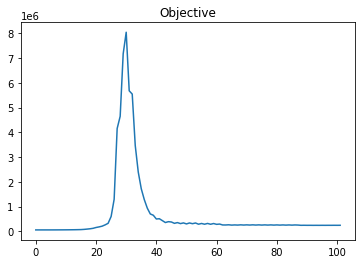

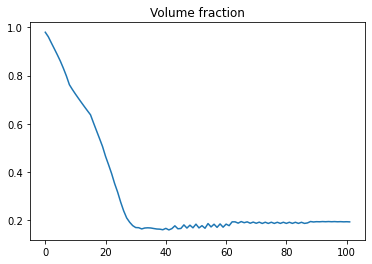

In [28]:
plt.plot(results['J'])
plt.title('Objective');
plt.figure()
plt.plot([g[0]+0.15 for g in results['G']])
plt.title('Volume fraction');